# Investigation of the loss function hessian

There is a conditional probability $p(\mathbf{y}|\mathbf{x})$, that maps the given unobserved variable $\mathbf{x}$ to the corresponding output $\mathbf{y}$, and which we try to approximate

Given the dataset
$$ \mathfrak{D} = \left\{ (\mathbf{x}_i, \mathbf{y}_i) \right\}, \quad i = 1, \ldots, m $$
The loss function calculated for all the given dataset of size $m$ is
$$ \mathcal{L}(\mathbf{w}) = \dfrac{1}{m} \sum\limits_{i=1}^{m} \ell(f_{\mathbf{w}}(\mathbf{x}_i), \mathbf{y}_i) \approx \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim p(\mathbf{x}, \mathbf{y})} \left[ \ell(f_{\mathbf{w}}(\mathbf{x}), \mathbf{y}) \right] $$
If we fix first $k$ samples, corresponding loss function is
$$ \mathcal{L}_k(\mathbf{w}) = \dfrac{1}{k} \sum\limits_{i=1}^{k} \ell(f_{\mathbf{w}}(\mathbf{x}_i), \mathbf{y}_i) $$
Difference between losses for sample sizes $k+1$ and $k$ is
$$ \mathcal{L}_{k+1}(\mathbf{w}) - \mathcal{L}_k(\mathbf{w}) = \dfrac{1}{k+1} \left( \ell(f_{\mathbf{w}}(\mathbf{x}_{k+1}), \mathbf{y}_{k+1}) - \mathcal{L}_{k}(\mathbf{w}) \right) $$
We can use Laplace approximation at optima $\mathbf{w}^*$:
$$ \ell(f_{\mathbf{w}}(\mathbf{x}_i), \mathbf{y}_i) \approx \ell(f_{\mathbf{w}^*}(\mathbf{x}_i), \mathbf{y}_i) + \dfrac{1}{2} (\mathbf{w} - \mathbf{w}^*)^\top \mathbf{H}_i(\mathbf{w}^*) (\mathbf{w} - \mathbf{w}^*) $$
Therefore formula for the difference becomes
$$ \mathcal{L}_{k+1}(\mathbf{w}) - \mathcal{L}_k(\mathbf{w}) = \dfrac{1}{k+1} \left( \ell(f_{\mathbf{w}^*}(\mathbf{x}_{k+1}), \mathbf{y}_{k+1}) - \dfrac{1}{k} \sum\limits_{i=1}^{k} \ell(f_{\mathbf{w}^*}(\mathbf{x}_{i}), \mathbf{y}_{i}) \right) + $$
$$ + \dfrac{1}{k+1} (\mathbf{w} - \mathbf{w}^*)^\top \left( \mathbf{H}_{k+1}(\mathbf{w}^*) - \dfrac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_{i}(\mathbf{w}^*) \right) (\mathbf{w} - \mathbf{w}^*) $$
- If we suppose $\mathbf{w}^*$ to be **global** optima, that is $\ell(f_{\mathbf{w}^*}(\mathbf{x}_{i}), \mathbf{y}_{i}) = 0$ for all $i = 1, \ldots, k+1$, therefore we can derive
    $$ \mathcal{L}_{k+1}(\mathbf{w}) - \mathcal{L}_k(\mathbf{w}) = \dfrac{1}{k+1} (\mathbf{w} - \mathbf{w}^*)^\top \left( \mathbf{H}_{k+1}(\mathbf{w}^*) - \dfrac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_{i}(\mathbf{w}^*) \right) (\mathbf{w} - \mathbf{w}^*) $$
    After that we can evaluate
    $$ \left| \mathcal{L}_{k+1}(\mathbf{w}) - \mathcal{L}_k(\mathbf{w}) \right| \leqslant \dfrac{1}{k+1} \| \mathbf{w} - \mathbf{w}^* \|_2^2 \left\| \mathbf{H}_{k+1}(\mathbf{w}^*) - \dfrac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_{i}(\mathbf{w}^*) \right\|_2 $$

Big question is norm of the difference
$$ \left\| \mathbf{H}_{k+1}(\mathbf{w}^*) - \frac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_i(\mathbf{w}^*) \right\|_2 = \text{?} $$

## Imports

In [264]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}
plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

SEED = 307
np.random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Linear Regression + MSE

$$ f_{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} $$
$$ \ell(f_{\mathbf{w}}(\mathbf{x}), \mathbf{y}) = \left( y - f_{\mathbf{w}}(\mathbf{x}) \right)^2 = \left( y - \mathbf{w}^\top \mathbf{x} \right)^2 $$
$$ \mathbf{H}_i(\mathbf{w}) = \mathbf{H}_i = 2 \mathbf{x}_i \mathbf{x}_i^\top $$ 

In [300]:
import scipy.stats as st

n = 100

mu = np.zeros(n) # expectation of x
Sigma = np.identity(n) # covariance matrix of x
alpha = 1
sigma2 = 1

x_distr = st.multivariate_normal(mean=mu, cov=Sigma)
w_star = st.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)

### Explicitly

In [303]:
np.random.seed(SEED)

m = 1000
X = np.array([])
Y = []
norms = []

for k in range(m):
    x = x_distr.rvs()
    y = w_star @ x + np.random.normal(scale=sigma2**0.5)
    xxT = np.outer(x, x)
    mean_xxT = X.T @ X / len(X) if len(X) > 0 else np.zeros((x.size, x.size))
    norms.append(np.linalg.norm(2 * (xxT - mean_xxT), ord=2))
    X = np.vstack((X, x)) if len(X) > 0 else x
    Y.append(y)

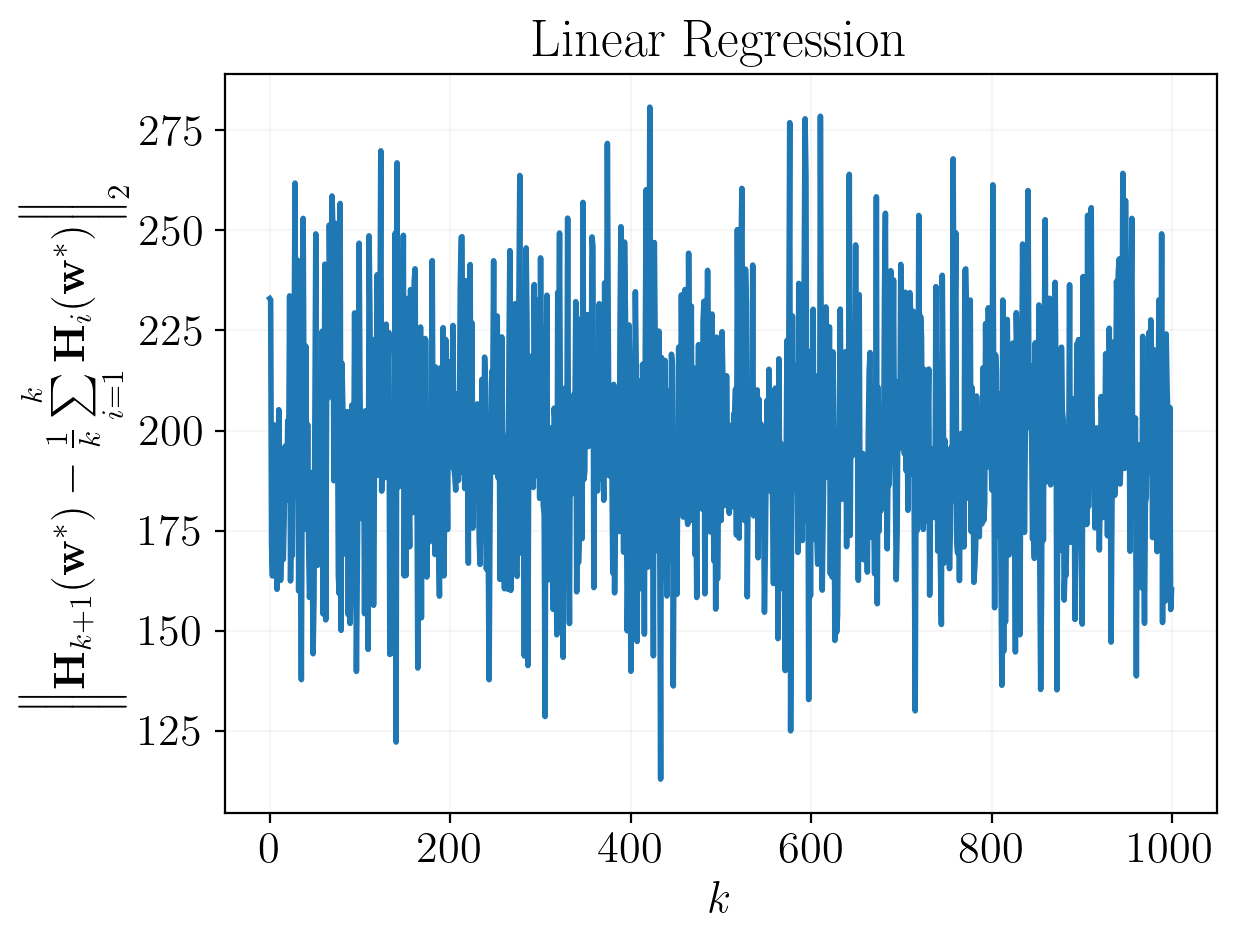

In [304]:
plt.plot(norms)
plt.title('Linear Regression')
plt.xlabel(r'$k$')
plt.ylabel(r'$\left\| \mathbf{H}_{k+1}(\mathbf{w}^*) - \frac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_i(\mathbf{w}^*) \right\|_2$')
plt.show()

### Via jax

In [284]:
import jax
import jax.numpy as jnp

In [270]:
@jax.jit
def f(w, x):
    return jnp.dot(w, x)

@jax.jit
def ell(w, x, y):
    return (y - f(w, x)) ** 2

@jax.jit
def L(w, X, Y):
    return jnp.mean(jnp.array([ell(w, x, y) for (x, y) in zip(X, Y)])) if len(X) > 0 else 0

@jax.jit
def diff(w, x, y, X, Y):
    return ell(w, x, y) - L(w, X, Y)

@jax.jit
def diff_grad(w, x, y, X, Y):
    return jax.grad(diff)(w, x, y, X, Y)

@jax.jit
def diff_hess(w, x, y, X, Y):
    return jax.hessian(diff)(w, x, y, X, Y)

In [271]:
np.random.seed(SEED)

X = np.array([])
Y = []
norms = []

for k in range(m):
    x = x_distr.rvs()
    y = w_star @ x + np.random.normal(scale=sigma2**0.5)
    norm = np.linalg.norm(diff_hess(w_star, x, y, X, Y), ord=2)
    norms.append(norm)
    X = np.vstack((X, x)) if len(X) > 0 else x
    Y.append(y)

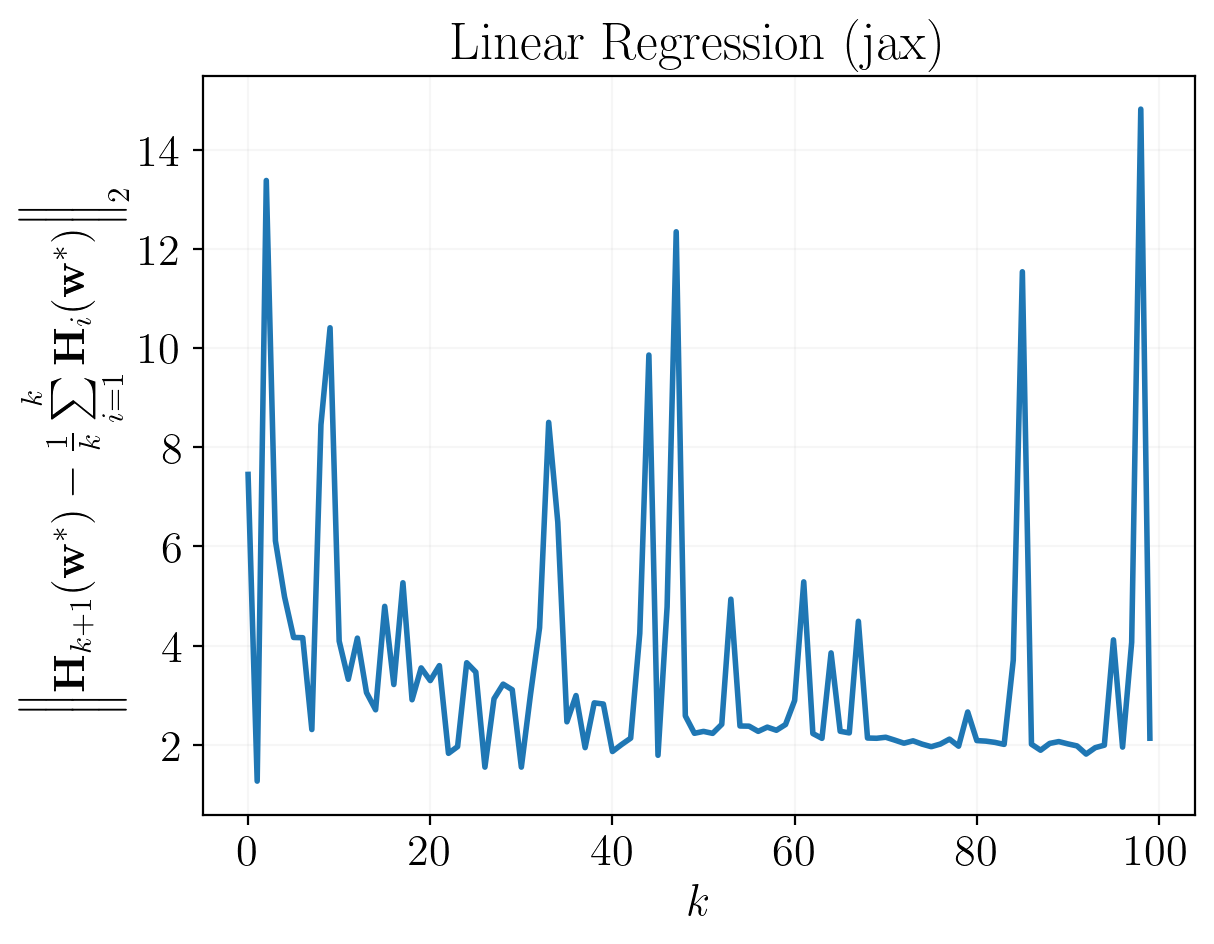

In [272]:
plt.plot(norms)
plt.title('Linear Regression (jax)')
plt.xlabel(r'$k$')
plt.ylabel(r'$\left\| \mathbf{H}_{k+1}(\mathbf{w}^*) - \frac{1}{k} \sum\limits_{i=1}^{k} \mathbf{H}_i(\mathbf{w}^*) \right\|_2$')
plt.show()

## MLP + MSE

$$ \ell(f_{\mathbf{w}}(\mathbf{x}), \mathbf{y}) = \left( y - f_{\mathbf{w}}(\mathbf{x}) \right)^2 $$ 

In [209]:
import torch
import torch.nn as nn

In [254]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        if hidden_sizes is None:
            self.hidden_sizes = [8, 1]
        else:
            self.hidden_sizes = hidden_sizes.append(1)
        
        self.layers = nn.ModuleList()
        for output_size in self.hidden_sizes:
            self.layers.append(nn.Linear(input_size, output_size))
            input_size = output_size
        self.mlp = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.mlp(x)

In [259]:
mlp = MLP(input_size=n, output_size=1)

In [260]:
def get_num_params(model):
    return sum([np.prod(param.size()) for param in model.parameters()])

In [261]:
get_num_params(mlp)

33

In [263]:
def f(w, x):
    return mlp(x)

In [ ]:
torch.autograd.functional.hessian()

In [207]:
jax.nn.relu(2)

Array(2, dtype=int32, weak_type=True)

In [ ]:
def f(w, x):
    return jnp.dot(w, x)